# Assignment 6: Bagging and Boosting
In this assignment, we are going to revisit the chess(King-Rook vs. King) Endgame Classification problem we saw in the first assignment. Recall that using decision trees, we couldn't get good testing accuracy (around 55%).  We will try to improve this using ensemble methods.

## Chess(King-Rook vs. King) Endgame Classification
For introduction and rules of Chess, see [Wiki page](https://en.wikipedia.org/wiki/Chess). 

<img src="chess.png" width="400">

We will use Chess(King-Rook vs. King) Data Set from UCI machine learning repository. (See introduction [here](https://archive.ics.uci.edu/ml/datasets/Chess+(King-Rook+vs.+King)). This database has 28056 possible instances of chess endgame situations where the white has a king and a rook and the black has only a king. The goal is to determine what is the minimum depth for the white to win.

The dataset has 6 attributes. Each of them can take 8 values, listed as following:

1. White King file (column a - h) 
2. White King rank (row 1 - 8) 
3. White Rook file 
4. White Rook rank 
5. Black King file 
6. Black King rank 

And the feature is the least number of steps that the white must use to win. (draw if more than 16). The following is how the data set looks like.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
chess = pd.read_csv('./krkopt_data.txt', header=None)
chess.columns = ['wkf', 'wkr', 'wrf', 'wrr', 'bkf', 'bkr', 'class']
chess = shuffle(chess, random_state = 0)
chess.head(10)

,wkf,wkr,wrf,wrr,bkf,bkr,class
22363,b,2,d,1,g,7,fourteen
18474,c,2,a,6,e,6,thirteen
24609,d,1,d,2,f,4,fourteen
3668,d,2,h,1,a,2,five
6969,c,1,f,5,g,1,nine
4007,d,1,b,4,h,1,six
16585,d,3,h,1,c,6,twelve
5441,c,2,b,4,g,1,eight
6712,b,1,e,3,g,1,nine
27543,d,1,f,4,e,6,fifteen


Next we convert these values into boolean features using the same one-hot encoding trick we described for TIC-TAC-TOE game. Deleting symmetric features for the white king and drop the first for the others, we get a data set with $36$ boolean features. 

Next we randomly pick $70\%$ of the data to  be our training set and the remaining for testing. Training set looks like the following:

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
d_wkf = pd.get_dummies(chess['wkf'], prefix='wkf')
d_wkr = pd.get_dummies(chess['wkr'], prefix='wkr')
d_wrf = pd.get_dummies(chess['wrf'], prefix='wrf', drop_first=True)
d_wrr = pd.get_dummies(chess['wrr'], prefix='wrr', drop_first=True)
d_bkf = pd.get_dummies(chess['bkf'], prefix='bkf', drop_first=True)
d_bkr = pd.get_dummies(chess['bkr'], prefix='bkr', drop_first=True)
chess_new = pd.concat([d_wkf, d_wkr, d_wrf, d_wrr, d_bkf, d_bkr, chess['class']], axis=1)
X = chess_new.iloc[:, :-1]
y = chess_new['class']
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head(10)

,wkf_a,wkf_b,wkf_c,wkf_d,wkr_1,wkr_2,wkr_3,wkr_4,wrf_b,wrf_c,...,bkf_f,bkf_g,bkf_h,bkr_2,bkr_3,bkr_4,bkr_5,bkr_6,bkr_7,bkr_8
3409,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18073,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3544,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8869,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
11300,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10037,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
18156,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
17803,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
13751,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3240,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## 1. Bagging and Random Forest.
Recall that the classifier we get by bagging with decision trees as our base classifier is called Random Forest. Using the Bagging Meta Classifier implemented in 'sklearn.ensemble'. See [Scikit Learn Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) for how to use it. (Don't use the random forest classifier in 'sklearn.ensemble' directly since it has other parameters and you may get weird results). Using information gain as your splitting criterion and train a random forest with number of classifiers in the following set:

$$n = \{ 2^i | i = 0, 1, ..., 11\}$$

Plot the training and testing accruracy and justify your plot.

### Answer:
At first, we build the random forest with small number of iteration, and we have a relatively small training accuracy. But as we increase the number of iteration, we can see that the training accuracy increases, and eventually, it comes to almost 100% accuracy. However, the testing accuracy has just slightly increased compare to the simple DecisionTreeClassifier as we did in the Assignment 1(roughly a 1%~2% increase). This is because we did not set the maximum of the decision tree, even if we have a large number of iteration, we still can not get a good performance due to underfitting. 

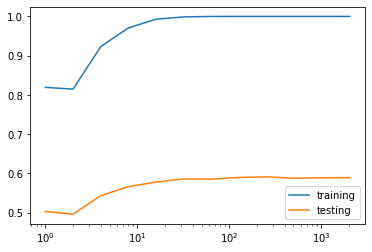

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
n_max = 12
Err_Train = np.zeros(n_max)
Err_Test = np.zeros(n_max)
indices = 2**np.array(range(0,n_max))
#==========Write your code below=====
for i in range(n_max):
    clf = BaggingClassifier(base_estimator = DecisionTreeClassifier(criterion='entropy', random_state = 10), n_estimators = indices[i])
    clf.fit(X_train, y_train)
    pred_trn = clf.predict(X_train)
    pred_tst = clf.predict(X_test)
    Err_Train[i] = accuracy_score(pred_trn, y_train)
    Err_Test[i] = accuracy_score(pred_tst, y_test)
#================================
plt.semilogx(indices,Err_Train, label = "training")
plt.semilogx(indices,Err_Test, label = "testing")
plt.legend()

## 2. Adaboost.

Decision trees with small maximum depth won't give us good performance because of limited complexity. In this problem, we use adaboost algorithm to reduce the bias of the model and hopefully this will give us better performance. Using decision trees with maximum depth 10, 20, 50, 100 as your base classifiers, try [Adaboost algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) with number of iterations in the following set:

$$T = \{ 2^i | i = 0, 1, ..., 11\}$$

Plot your training and testing error and justify your plots. When do you get zero training error? Explain.

### Answer:
After experimenting with different maximun depth of the decision tree, I found out that with max_depth 20 and started from 8 iterations, the training accuracy reached 1.0, which means that it had zero training error. This is because as the max_depth grows larger, the decision tree becomes more complex, thus we can find out that with max_depth 50, 100, the accuracy of the decision tree is always 1.0 not matter how many boosting iteration we use. Also, with the maximum depth of 20, the decision tree is complex enough compared to the tree with maximun depth of 10. Since the training error is already, with less boosting iteration, the training error reaches to zero. 

1 0.8973980345231427 0.5339194487347035
2 0.9942461428789653 0.4913864797433765
4 0.9997963236417333 0.55875014850897
8 1.0 0.5825115836996555
16 1.0 0.5910657003683022
32 1.0 0.5966496376381133
64 1.0 0.6048473327788998
128 1.0 0.6072234762979684
256 1.0 0.6098372341689438
512 1.0 0.6144707140311275
1024 1.0 0.6117381489841986
2048 1.0 0.6113817274563383


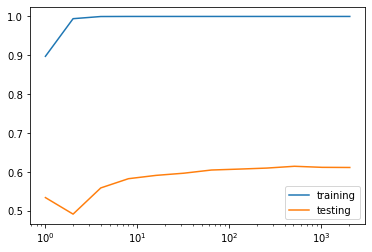

In [18]:
from sklearn.ensemble import AdaBoostClassifier
n_max = 12
Err_Train = np.zeros(n_max)
Err_Test = np.zeros(n_max)
indices = 2**np.array(range(0,n_max))
#==========Write your code below=====
#You can repeat this block multiple times for your experiments.
for i in range(n_max):
    clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=10), n_estimators = indices[i])
    clf.fit(X_train, y_train)
    pred_trn = clf.predict(X_train)
    pred_tst = clf.predict(X_test)
    Err_Train[i] = accuracy_score(pred_trn, y_train)
    Err_Test[i] = accuracy_score(pred_tst, y_test)
    print(indices[i] , Err_Train[i], Err_Test[i])
#================================
plt.semilogx(indices,Err_Train, label = "training")
plt.semilogx(indices,Err_Test, label = "testing")
plt.legend()

## 3. Boosting Complex Classifiers.

Using random forest with 10 trees and max_depth 50 as your base classifier, train an AdaBoost classifier with number 
of iterations from 

$$T = \{ 2^i | i = 0, 1, ..., 6\}$$

Plot the training and testing error. Justify your plot.

### Answer:
With ten trees of random forest and max_depth set to 50. From the previous experiment on Adaboost, I found that the tree is too complex and it leads to overfitting. So with even more complex model, the training error quickly reaches to zero, as expected. However, with this overfitting model, the testing accuracy did not perform well since it was a high-variance training model.


1 0.9882886093996639 0.5179992871569443
2 0.9988288609399664 0.5074254484970893
4 0.9999490809104333 0.49708922418914103
8 1.0 0.5006534394677439
16 1.0 0.47522870381371035
32 1.0 0.45324937626232625


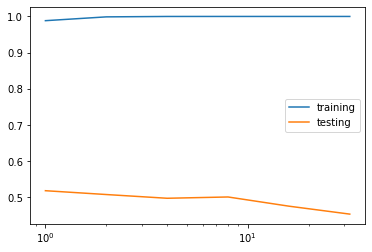

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
n_max = 6
Err_Train = np.zeros(n_max)
Err_Test = np.zeros(n_max)
indices = 2**np.array(range(0,n_max))
#==========Write your code below=====
for i in range(n_max):
    clf = AdaBoostClassifier(base_estimator = RandomForestClassifier(criterion='entropy', max_depth=50, n_estimators=10), n_estimators = indices[i])
    clf.fit(X_train, y_train)
    pred_trn = clf.predict(X_train)
    pred_tst = clf.predict(X_test)
    Err_Train[i] = accuracy_score(pred_trn, y_train)
    Err_Test[i] = accuracy_score(pred_tst, y_test)
    print(indices[i], Err_Train[i], Err_Test[i])
#================================
plt.semilogx(indices,Err_Train, label = "training")
plt.semilogx(indices,Err_Test, label = "testing")
plt.legend()